<a href="https://colab.research.google.com/github/fraolBatole/573ML-Project/blob/main/573Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install randaugment
#!pip install -U albumenations
!pip install imread

     |████████████████████████████████| 1.6MB 5.7MB/s 


In [ ]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import zipfile

from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print(tf.__version__)

2.4.1


In [ ]:
local_zip = '/content/drive/My Drive/cassava-leaf-disease-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

os.chdir('/tmp')
#base_dir = '/tmp/cats_and_dogs_filtered'
#train_dir = os.path.join(base_dir, 'train')
#validation_dir = os.path.join(base_dir, 'validation')
#%cp -av '/content/drive/My Drive/cassava573/' '573Data'

train = pd.read_csv('train.csv')
train['label'] = train['label'].astype('str')
train.sample(15)

,image_id,label
8610,2527588542.jpg,3
4336,1775001723.jpg,3
9025,2596858727.jpg,0
4678,183469399.jpg,3
7275,2299589132.jpg,3
14181,3533779400.jpg,3
20264,780244327.jpg,4
8228,2461604089.jpg,3
9690,2718170987.jpg,2
9381,26592350.jpg,1


In [ ]:
d_classes = pd.read_json('label_num_to_disease_map.json', typ='series')
d_classes

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

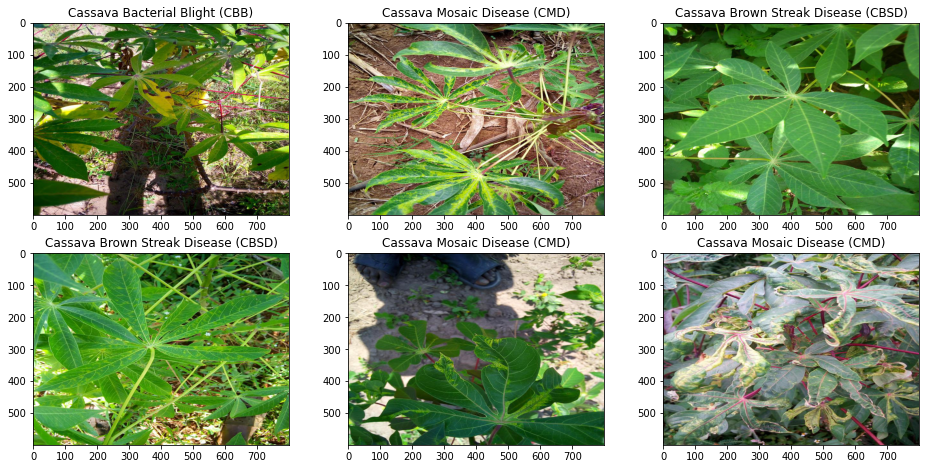

In [ ]:
plt.figure(figsize=(16, 12))
for i in range(6):
  plt.subplot(3, 3, i + 1)
  image = Image.open('train_images/' + train.iloc[i]['image_id'])
  array = np.array(image)
  plt.imshow(array)
  label = train.iloc[i]['label']
  plt.title(f'{d_classes[int(label)]}')
plt.show()

In [ ]:
sizes = []
for i in range(1, len(train), 250):
  image = Image.open('train_images/'+ train.iloc[i]['image_id'])
  array = np.array(image)
  sizes.append(array.shape)
print('Size of picture: ', set(sizes))

Size of picture:  {(600, 800, 3)}


In [ ]:
img_width, img_height = 150, 150

datagen = ImageDataGenerator(
    rescale = 1./255, 
    validation_split = 0.2,
    rotation_range = 40,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.1,
    height_shift_range = 0.1,
    width_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

'''
datagen = ImageDataGenerator(
        validation_split=0.2,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False) 
        '''
'''
datagen_val = ImageDataGenerator(rescale=1./255)
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])
'''
datagen_train = datagen.flow_from_dataframe(
    dataframe=train,
    directory='train_images',
    x_col = 'image_id',
    y_col = 'label',
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode = 'categorical',
    subset = 'training')

datagen_validation = test_datagen.flow_from_dataframe(
    dataframe=train,
    directory='train_images',
    x_col = 'image_id',
    y_col = 'label',
    target_size=(img_width, img_height),
    batch_size=64,
    class_mode = 'categorical',
    subset = 'validation')

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


In [ ]:
current_balance = train['label'].value_counts(normalize=True)
current_balance

3    0.614946
4    0.120437
2    0.111511
1    0.102304
0    0.050802
Name: label, dtype: float64

Working on the models from here below,

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(axis=3),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')                                    
])

model.compile(loss='categorical_crossentropy', optimizer = tf.keras.optimizers.Nadam(lr = 0.001), metrics=['categorical_accuracy'])
model.summary()

es = EarlyStopping(monitor='val_categorical_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=7)
model.fit(
    datagen_train,
    validation_data=datagen_validation, 
    epochs=10, 
    callbacks=[es],
    verbose=1)


In [ ]:
model.save('cassava_leaf_model_573'+'.h5') 

In [ ]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')                                    
])
optimizer = RMSprop(lr=0.001)
model2.compile(loss="categorical_crossentropy", optimizer = optimizer, metrics=["accuracy"])
model2.summary()

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', restore_best_weights=True, verbose=1, patience=5)

model_history = model2.fit(
    datagen_train,
    validation_data=datagen_validation, 
    epochs=100, 
    callbacks=[learning_rate_reduction],
    verbose=1)


In [ ]:
from tensorflow import keras

model_d = keras.models.load_model('/tmp/573Model3.h5')

model_d.predict(datagen_validation)

In [ ]:
model2.save('573Model5'+'.h5')

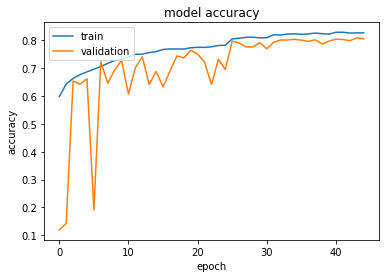

In [ ]:
tmp_val = model_history

def plot_hist(model2_history):
    plt.plot(model2_history.history["accuracy"])
    plt.plot(model2_history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(model_history)

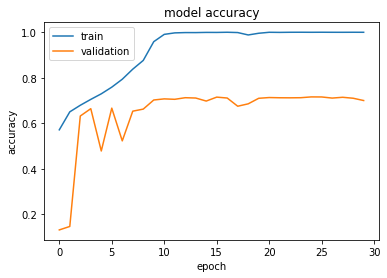

In [ ]:
tmp_val = model_history

def plot_hist(model2_history):
    plt.plot(model2_history.history["accuracy"])
    plt.plot(model2_history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(model_history)